In [0]:
import sys
print(sys.version)

CURR_DIR = '/content/drive/My Drive/google_colab_work/detailed_probabilistic_robotics/'
sys.path.append(CURR_DIR)

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


In [0]:
from dp_policy_agent import *

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
class StateInfo:
    def __init__(self, action_num, epsilon=0.3):
        self.q = np.zeros(action_num)
        self.epsilon = epsilon

    def pi(self):
        return self.epsilon_greedy(self.epsilon)

    def greedy(self):
        return np.argmax(self.q)

    def epsilon_greedy(self, epsilon):
        if random.random() < epsilon:
            return random.choice(range(len(self.q)))
        else:
            return self.greedy()

    def max_q(self):
        return max(self.q)

# SARSA

In [0]:
class SarsaAgent(DpPolicyAgent):
    def __init__(
        self, time_interval, estimator, policy_file_path, value_file_path,
        alpha=0.5, widths=np.array([0.2, 0.2, math.radians(10)]), puddle_coef=100, lower_left=np.array([-4,-4]), upper_right=np.array([4,4])
    ):
        super().__init__(
            time_interval, estimator, None, policy_file_path,
            widths, puddle_coef, lower_left, upper_right
        )
        n_x, n_y, n_theta = self.index_nums
        self.indexes = list(itertools.product(range(n_x), range(n_y), range(n_theta)))
        self.actions = list(set([tuple(self.policy_data[index]) for index in self.indexes]))
        self.state_space = self.set_action_value_function(value_file_path)

        ### For reinforcement learning
        self.alpha = alpha
        self.s = None
        self.a = None
        self.update_end = False

    def set_action_value_function(self, value_file_path):
        state_space = {}
        for line in open(value_file_path, 'r'):
            data = line.split()
            state_index = (int(data[0]), int(data[1]), int(data[2]))
            value = float(data[3])

            state_space[state_index] = StateInfo(len(self.actions))
            for action_id, action in enumerate(self.actions):
                state_space[state_index].q[action_id] = value if action==tuple(self.policy_data[state_index]) else value - 0.1

        return state_space

    def policy(self, pose, goal=None):
       state_index = self.pose2index(pose, self.pose_min, self.index_nums, self.widths)
       action_id = self.state_space[state_index].pi()
       return tuple(state_index), action_id

    def decision(self, obs=None):
        if self.update_end:
            nu = 0.0 # [m/s]
            omega = 0.0 # [rad/s]
            return nu, omega
        if self.is_goal:
            self.update_end = True
            
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.estimator.observation_update(obs)

        s_, a_ = self.policy(self.estimator.pose)
        r = self.time_interval*self.reward_per_sec()
        self.total_reward += r
        self.q_update(self.s, self.a, r, s_, a_)
        self.s = s_
        self.a = a_

        self.prev_nu, self.prev_omega = self.actions[a_]
        return self.prev_nu, self.prev_omega

    def q_update(self, prev_s, prev_a, r, curr_s, curr_a):
        if prev_s == None:
            return

        prev_q = self.state_space[prev_s].q[prev_a] 
        curr_q = self.state_space[curr_s].q[curr_a] if not self.is_goal else self.final_value
        
        new_q = (1.0 - self.alpha)*prev_q + self.alpha*(r + curr_q)
        self.state_space[prev_s].q[prev_a] = new_q

In [0]:
class WarpRobot(Robot):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.init_agent = copy.deepcopy(self.agent)

    def choose_pose(self):
        xy = random.random()*6 - 2
        theta = random.random()*math.radians(360)
        pose = np.array([3, xy, theta]) if 0.5<=random.random() else np.array([xy, 3, theta])
        return pose 

    def reset(self):
        tmp = self.agent.state_space
        self.agent = copy.deepcopy(self.init_agent)
        self.agent.state_space = tmp

        self.pose = self.choose_pose()
        self.agent.estimator.belief = scipy.stats.multivariate_normal(mean=self.pose, cov=np.diag([1.0e-10, 1.0e-10, 1.0e-10]))
        self.poses = []

    def one_step(self, time_interval):
        if self.agent.update_end:
            with open('log.txt', 'a') as f:
                f.write('{}\n'.format(self.agent.total_reward + self.agent.final_value))
            self.reset()
            return

        super().one_step(time_interval)

In [0]:
def trial():
    time_span = 60
    time_interval = 0.1
    world = PuddleWorld(time_span, time_interval, debug=False)

    m = Map()
    for landmark in [(-4,2), (2,-3), (4,4), (-4,-4)]:
        m.append_landmark(Landmark(*landmark))
    world.append(m)

    goal = Goal(-3, -3)
    world.append(goal)

    world.append(Puddle(lower_left=(-2, 0), upper_right=(0, 2), depth=0.1))
    world.append(Puddle(lower_left=(-0.5, -2), upper_right=(2.5, 1), depth=0.1))

    policy_file_path = CURR_DIR + 'sensor_data/puddle_ignore_policy.txt'
    value_file_path = CURR_DIR + 'sensor_data/puddle_ignore_values.txt'

    init_pose = np.array([3, 3, math.radians(0)])
    kf_estimator = KalmanFilter(m, init_pose)
    sarsa_agent = SarsaAgent(time_interval, kf_estimator, policy_file_path, value_file_path)

    robot = WarpRobot(
        init_pose, agent=sarsa_agent,
        sensor=Camera(m, distance_bias_rate_std=0, direction_bias_std=0),
        color='red', bias_rate_stds=(0,0)
    )
    world.append(robot)

    world.draw()
    return world, sarsa_agent

In [0]:
world, agent = trial()
world.ani

Output hidden; open in https://colab.research.google.com to view.

In [0]:
%matplotlib inline
print(matplotlib.get_backend())

module://ipykernel.pylab.backend_inline


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


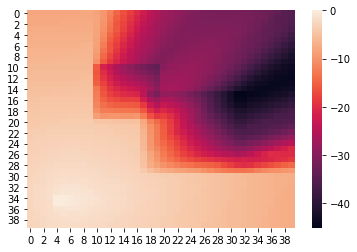

In [0]:
v = np.zeros(agent.index_nums[0:2])
for i_x in range(agent.index_nums[0]):
    for i_y in range(agent.index_nums[1]):
        v[i_x, i_y] = agent.state_space[(i_x, i_y, 18)].max_q()
        
sns.heatmap(np.rot90(v), square=False)
plt.show()

2.0: Turn left, 1.0: Go straight, -2.0: Turn right


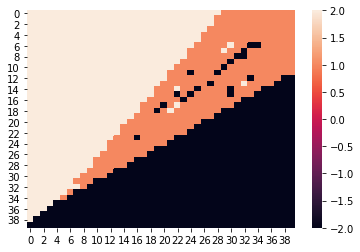

In [0]:
p = np.zeros(agent.index_nums[0:2])
for i_x in range(agent.index_nums[0]):
    for i_y in range(agent.index_nums[1]):
        action_id = agent.state_space[(i_x, i_y, 22)].greedy()
        nu = agent.actions[action_id][0]
        omega = agent.actions[action_id][1]
        p[i_x, i_y] = nu + omega
        
print('2.0: Turn left, 1.0: Go straight, -2.0: Turn right')
sns.heatmap(np.rot90(p), square=False)
plt.show()

# n-step SARSA

In [0]:
class NstepSarsaAgent(SarsaAgent):
    def __init__(
        self, time_interval, estimator, policy_file_path, value_file_path,
        alpha=0.5, widths=np.array([0.2, 0.2, math.radians(10)]), puddle_coef=100, lower_left=np.array([-4,-4]), upper_right=np.array([4,4]),
        n_step=10
    ):
        super().__init__(
            time_interval, estimator, policy_file_path, value_file_path,
            alpha, widths, puddle_coef, lower_left, upper_right
        )

        self.s_trace = []
        self.a_trace = []
        self.r_trace = []
        self.n_step = n_step

    def set_action_value_function(self, value_file_path):
        state_space = {}
        for index in self.indexes:
            state_space[index] = StateInfo(len(self.actions))
            for action_id, action in enumerate(self.actions):
                state_space[index].q[action_id] = -1000.0
        return state_space

    def decision(self, obs=None):
        if self.update_end:
            nu = 0.0 # [m/s]
            omega = 0.0 # [rad/s]
            return nu, omega
        if self.is_goal:
            self.update_end = True
            
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.estimator.observation_update(obs)

        s_, a_ = self.policy(self.estimator.pose)
        r = self.time_interval*self.reward_per_sec()
        self.r_trace.append(r)
        self.total_reward += r
        self.q_update(s_, a_, self.n_step)
        self.s_trace.append(s_)
        self.a_trace.append(a_)

        self.prev_nu, self.prev_omega = self.actions[a_]
        return self.prev_nu, self.prev_omega

    def q_update(self, curr_s, curr_a, n_step):
        if len(self.s_trace) < n_step or n_step == 0:
            return

        n_step_prev_s = self.s_trace[-n_step]
        n_step_prev_a = self.a_trace[-n_step]

        n_step_prev_q = self.state_space[n_step_prev_s].q[n_step_prev_a] 
        cumsum_r = sum(self.r_trace[-n_step:])
        curr_q = self.state_space[curr_s].q[curr_a] if not self.is_goal else self.final_value

        new_q = (1.0 - self.alpha)*n_step_prev_q + self.alpha*(cumsum_r + curr_q)
        self.state_space[n_step_prev_s].q[n_step_prev_a] = new_q

        if self.is_goal:
            self.q_update(curr_s, curr_a, n_step-1)

In [0]:
class WarpRobot2(WarpRobot):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def choose_pose(self):
        x = 8*random.random() - 4
        y = 8*random.random() - 4
        theta = math.radians(360)*random.random()
        return np.array([x, y, theta])

    def one_step(self, time_interval):
        reset_time = 30 # [sec]
        reset_steps = int(round(reset_time/time_interval)) # [step]

        if self.agent.update_end:
            with open('log.txt', 'a') as f:
                f.write('{}\n'.format(self.agent.total_reward + self.agent.final_value))
            self.reset()
            return
        elif reset_steps < len(self.poses):
            with open('log.txt', 'a') as f:
                f.write('DNF\n')
            self.reset()
            return

        super().one_step(time_interval)

In [0]:
def trial():
    time_span = 60
    time_interval = 0.1
    world = PuddleWorld(time_span, time_interval, debug=False)

    m = Map()
    for landmark in [(-4,2), (2,-3), (4,4), (-4,-4)]:
        m.append_landmark(Landmark(*landmark))
    world.append(m)

    goal = Goal(-3, -3)
    world.append(goal)

    world.append(Puddle(lower_left=(-2, 0), upper_right=(0, 2), depth=0.1))
    world.append(Puddle(lower_left=(-0.5, -2), upper_right=(2.5, 1), depth=0.1))

    policy_file_path = CURR_DIR + 'sensor_data/puddle_ignore_policy.txt'
    value_file_path = CURR_DIR + 'sensor_data/puddle_ignore_values.txt'

    init_pose = np.array([3, 3, math.radians(0)])
    kf_estimator = KalmanFilter(m, init_pose)
    nstep_sarsa_agent = NstepSarsaAgent(time_interval, kf_estimator, policy_file_path, value_file_path)

    robot = WarpRobot2(
        init_pose, agent=nstep_sarsa_agent,
        sensor=Camera(m, distance_bias_rate_std=0, direction_bias_std=0),
        color='red', bias_rate_stds=(0,0)
    )
    world.append(robot)

    world.draw()
    return world, nstep_sarsa_agent

In [0]:
world, agent = trial()
world.ani

Output hidden; open in https://colab.research.google.com to view.

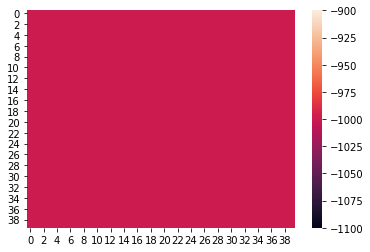

In [0]:
v = np.zeros(agent.index_nums[0:2])
for i_x in range(agent.index_nums[0]):
    for i_y in range(agent.index_nums[1]):
        v[i_x, i_y] = agent.state_space[(i_x, i_y, 18)].max_q()
        
sns.heatmap(np.rot90(v), square=False)
plt.show()

2.0: Turn left, 1.0: Go straight, -2.0: Turn right


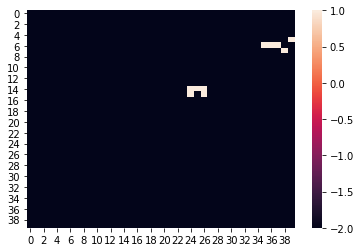

In [0]:
p = np.zeros(agent.index_nums[0:2])
for i_x in range(agent.index_nums[0]):
    for i_y in range(agent.index_nums[1]):
        action_id = agent.state_space[(i_x, i_y, 22)].greedy()
        nu = agent.actions[action_id][0]
        omega = agent.actions[action_id][1]
        p[i_x, i_y] = nu + omega
        
print('2.0: Turn left, 1.0: Go straight, -2.0: Turn right')
sns.heatmap(np.rot90(p), square=False)
plt.show()

# SARSA (λ)

In [0]:
class SarsaLambdaAgent(SarsaAgent):
    def __init__(
        self, time_interval, estimator, policy_file_path, value_file_path,
        alpha=0.5, widths=np.array([0.2, 0.2, math.radians(10)]), puddle_coef=100, lower_left=np.array([-4,-4]), upper_right=np.array([4,4]),
        lmd=0.9
    ):
        super().__init__(
            time_interval, estimator, policy_file_path, value_file_path,
            alpha, widths, puddle_coef, lower_left, upper_right
        )

        self.s_trace = []
        self.a_trace = []
        self.lmd = lmd

    def set_action_value_function(self, value_file_path):
        state_space = {}
        for index in self.indexes:
            state_space[index] = StateInfo(len(self.actions))
            for action_id, action in enumerate(self.actions):
                state_space[index].q[action_id] = -1000.0
        return state_space

    def decision(self, obs=None):
        if self.update_end:
            nu = 0.0 # [m/s]
            omega = 0.0 # [rad/s]
            return nu, omega
        if self.is_goal:
            self.update_end = True
            
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.estimator.observation_update(obs)

        s_, a_ = self.policy(self.estimator.pose)
        r = self.time_interval*self.reward_per_sec()
        self.total_reward += r
        self.q_update(self.s, self.a, r, s_, a_)
        self.s_trace.append(s_)
        self.a_trace.append(a_)

        self.prev_nu, self.prev_omega = self.actions[a_]
        return self.prev_nu, self.prev_omega

    def q_update(self, prev_s, prev_a, r, curr_s, curr_a):
        if prev_s == None:
            return

        prev_q = self.state_space[prev_s].q[prev_a] 
        curr_q = self.state_space[curr_s].q[curr_a] if not self.is_goal else self.final_value
        delta_q = (r + curr_q) - prev_q

        for i in range(1, len(self.s_trace)+1):
            i_step_prev_s = self.s_trace[-i]
            i_step_prev_a = self.a_trace[-i]

            new_delta_q = self.alpha*(self.lmd**(i-1))*delta_q
            self.state_space[i_step_prev_s].q[i_step_prev_a] += new_delta_q

In [0]:
def trial():
    time_span = 60
    time_interval = 0.1
    world = PuddleWorld(time_span, time_interval, debug=False)

    m = Map()
    for landmark in [(-4,2), (2,-3), (4,4), (-4,-4)]:
        m.append_landmark(Landmark(*landmark))
    world.append(m)

    goal = Goal(-3, -3)
    world.append(goal)

    world.append(Puddle(lower_left=(-2, 0), upper_right=(0, 2), depth=0.1))
    world.append(Puddle(lower_left=(-0.5, -2), upper_right=(2.5, 1), depth=0.1))

    policy_file_path = CURR_DIR + 'sensor_data/puddle_ignore_policy.txt'
    value_file_path = CURR_DIR + 'sensor_data/puddle_ignore_values.txt'

    init_pose = np.array([3, 3, math.radians(0)])
    kf_estimator = KalmanFilter(m, init_pose)
    sarsa_lambda_agent = SarsaLambdaAgent(time_interval, kf_estimator, policy_file_path, value_file_path)

    robot = WarpRobot2(
        init_pose, agent=sarsa_lambda_agent,
        sensor=Camera(m, distance_bias_rate_std=0, direction_bias_std=0),
        color='red', bias_rate_stds=(0,0)
    )
    world.append(robot)

    world.draw()
    return world, sarsa_lambda_agent

In [0]:
world, agent = trial()
world.ani

Output hidden; open in https://colab.research.google.com to view.

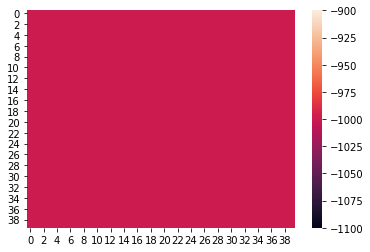

In [0]:
v = np.zeros(agent.index_nums[0:2])
for i_x in range(agent.index_nums[0]):
    for i_y in range(agent.index_nums[1]):
        v[i_x, i_y] = agent.state_space[(i_x, i_y, 18)].max_q()
        
sns.heatmap(np.rot90(v), square=False)
plt.show()

2.0: Turn left, 1.0: Go straight, -2.0: Turn right


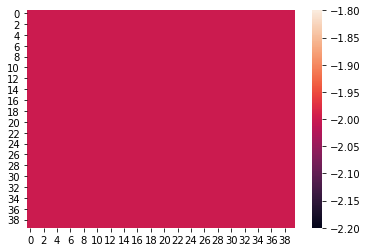

In [0]:
p = np.zeros(agent.index_nums[0:2])
for i_x in range(agent.index_nums[0]):
    for i_y in range(agent.index_nums[1]):
        action_id = agent.state_space[(i_x, i_y, 22)].greedy()
        nu = agent.actions[action_id][0]
        omega = agent.actions[action_id][1]
        p[i_x, i_y] = nu + omega
        
print('2.0: Turn left, 1.0: Go straight, -2.0: Turn right')
sns.heatmap(np.rot90(p), square=False)
plt.show()